# Tratamiento de imágenes - 2023 - Entregable 2

# Fecha de entrega: 5/5/2023

### Importante:   
En todos los ejercicios se espera que se entregue comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en celdas de texto agregadas a los notebooks o en un informe aparte.

Para la entrega se sube un **zip** (no rar, ni otro formato) con:
* El notebook del entregable modificado. El notebook debe tener las celdas ejecutadas con las salidas correspondientes. Debe tener todo lo necesario para poder ser ejecutado nuevamente
* Todo el resto del contenido del zip del entregable. Si, para mostrar resultados, usan en el notebook imágenes propias, deben incluirlas en la carpeta **imagenes**  del zip. 
* El informe en pdf en caso de no incluir las discusiones dentro del notebook en celdas "Markdown", o si les resulta más sencillo realizar el análisis en un documento aparte.

No se deben incluir en el zip de la entrega las imágenes de prueba que están disponibles en la página web del curso. Se asumirá que esas imágenes están en un directorio y se hará referencia a dichas imágenes en forma relativa a ese directorio (ver la celda siguiente).

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ---------------- 
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook 
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------



# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
# 
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = 'imagenes/'


# Directorio con la base de imágenes de documentos (para el ejercicio 5)
# En el notebook acceden a esos datos en forma relativa a donde tengan esas imagenes:
# 
# filename = os.path.join(dir_base_documentos, '0012183661.tif')
# I = imread(filename)
dir_base_documentos = '../base_documentos'


## Transformaciones geométricas

### 1. Implementar una función que realice transformaciones proyectivas

In [25]:

def bilineal(img, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I, 
    retorna la interpolación bilineal entre los cuatro pixeles de I más cercanos
    al punto de entrada.
    
    Args:
    - I (array 2D): Imagen de referencia para interpolar.    
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.
    
    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto. 
    """
    fila, columna=int(np.round(punto[0])), int(np.round(punto[1]))
    if fila<0 or columna<0 or fila>=np.shape(img)[1] or columna>=np.shape(img)[0]:
        return(color_de_fondo)
   
    fila+=1
    columna+=1
    x=punto[0]+1
    y=punto[1]+1
    J=np.pad(img, ((1,1),(1,1)), constant_values=color_de_fondo)
    x1=fila
    x2=fila+1
    y1=columna
    y2=columna+1
    q11 = J[columna, fila]
    q21 = J[columna, fila+1]
    q12 = J[columna+1, fila]
    q22 = J[columna+1, fila+1]
    a=(x2-x)/(x2-x1)*q11+(x-x1)/(x2-x1)*q21
    b=(x2-x)/(x2-x1)*q12+(x-x1)/(x2-x1)*q22
    valor_interpolado=(y2-y)/(y2-y1)*a+(y-y1)/(y2-y1)*b
    
    if valor_interpolado<0:
        valor_interpolado=0
    if valor_interpolado>254:
        valor_interpolado=254
    return int(valor_interpolado)


def vecino(img, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I, 
    retorna el nivel de gris correspondiente al pixel más cercano I.
    
    Args:
    - I (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.
    
    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto. 
    """
    fila, columna=int(np.round(punto[0])), int(np.round(punto[1]))

    if fila<0 or columna<0 or fila>=np.shape(img)[1] or columna>=np.shape(img)[0]:
        return(color_de_fondo)
    
    fila, columna=int(np.round(punto[0])), int(np.round(punto[1]))
    valor_interpolado=int(img[columna,fila])
    return valor_interpolado

def transformar(I, T, tipo_interpolacion='vecino', color_de_fondo=0):
    """
    Aplicar una transformacion geometrica T a imagen I, especificando el tipo de interpolacion.
    
    Args:
    - I (array 2D): imagen a transformar.
    - T (array 2D): matriz de transformacion de tamaño 3x3.
    - tipo_interpolacion (str): interpolación a utilizar: 'vecino' más cercano (default) o 'bilineal'.
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.
    
    Returns:
    I_transformada (array 2D): imagen transformada
    
    """
    
        
    # Obtener dimensiones de la imagen I
    altura, ancho= I.shape

    # Crear imagen de salida I_transformada
    I_transformada = np.zeros_like(I)
    T_inv=np.linalg.inv(T)
    # Iterar sobre cada píxel de la imagen de salida I_transformada
    for x in range(ancho):
        for y in range(altura):
            # Aplicar inversa de la transformación T al píxel (x, y)
            p_transformado = T_inv@ np.array([x, y, 1])
            if tipo_interpolacion == 'vecino':
                valor_interpolado = vecino(I, p_transformado, color_de_fondo)
            elif  tipo_interpolacion == 'bilineal':
                valor_interpolado = bilineal(I, p_transformado, color_de_fondo)
            I_transformada[y, x] = valor_interpolado
        
    return I_transformada

In [4]:
matriz = np.zeros((16, 22))
# asignar los valores a las posiciones específicas de la matriz
matriz[14, 20] = 91
matriz[15, 20] = 210
matriz[14, 21] = 162
matriz[15, 21] = 95
# Prueba la función bilineal con un punto de prueba y un valor de fondo de 128
valor_interpolado = bilineal(matriz, (20.2, 14.5), 128)
print(valor_interpolado) # Debería imprimir 146
valor_interpolado = vecino(matriz, (20.2, 14.5), 128)
print(valor_interpolado) # Debería imprimir 91

146
91


### 2. Usando la función transformar, mostrar ejemplos de transformaciones isométricas, afines y proyectivas  con diferentes interpolaciones

Parecido a lo que se muestra en estos ejemplos de scikit-image:  
https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html


#### Mostrar una rotación con origen en vértice superior izquierdo de la imagen (origen de coordenadas) 

[[ 0.9961947  -0.08715574  0.        ]
 [ 0.08715574  0.9961947   0.        ]
 [ 0.          0.          1.        ]]


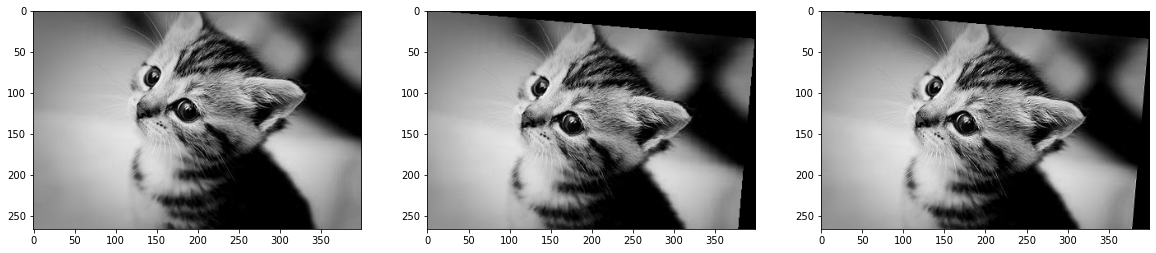

In [5]:
angulo = 5

# Crear la matriz de rotación
matriz_rotacion = np.array([[np.cos(np.deg2rad(angulo)), -np.sin(np.deg2rad(angulo)),0],
                            [np.sin(np.deg2rad(angulo)), np.cos(np.deg2rad(angulo)),0],[0,0,1]])
print(matriz_rotacion)

filenames = [dir_base_imagenes+'kitten.jpg']

I = cv2.imread(filenames[0])
I=I[:,:,0]
I_vecino=transformar(I, matriz_rotacion, tipo_interpolacion='vecino', color_de_fondo=0)
I_bilineal=transformar(I, matriz_rotacion, tipo_interpolacion='bilineal', color_de_fondo=0)
fig, axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(I,cmap="gray")
axs[1].imshow(I_vecino,cmap="gray")
axs[2].imshow(I_bilineal,cmap="gray")


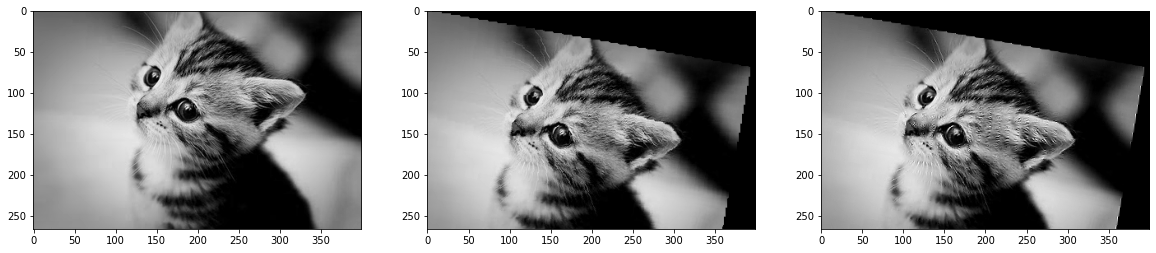

In [6]:
I_vecino=transformar(I_vecino, matriz_rotacion, tipo_interpolacion='vecino', color_de_fondo=0)
I_bilineal=transformar(I_bilineal, matriz_rotacion, tipo_interpolacion='bilineal', color_de_fondo=0)
fig, axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(I,cmap="gray")
axs[1].imshow(I_vecino,cmap="gray")
axs[2].imshow(I_bilineal,cmap="gray")

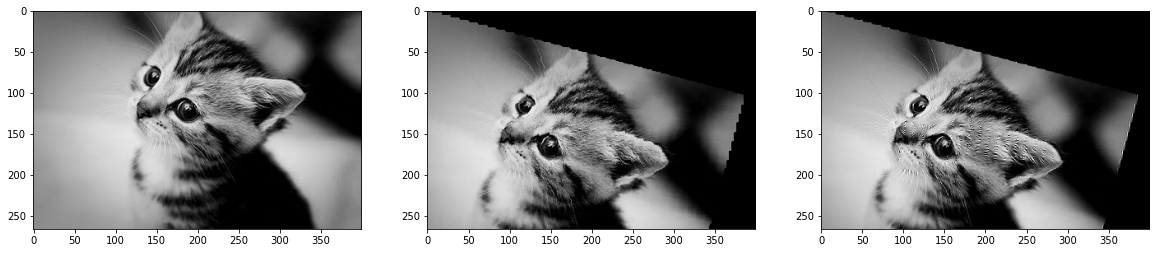

In [7]:
I_vecino=transformar(I_vecino, matriz_rotacion, tipo_interpolacion='vecino', color_de_fondo=0)
I_bilineal=transformar(I_bilineal, matriz_rotacion, tipo_interpolacion='bilineal', color_de_fondo=0)
fig, axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(I,cmap="gray")
axs[1].imshow(I_vecino,cmap="gray")
axs[2].imshow(I_bilineal,cmap="gray")

#### Mostrar una rotación con origen en el centro de la imagen
La transformación de rotación en el centro de la imagen puede calcularse como la composición de una traslación, una rotación y una traslación.  

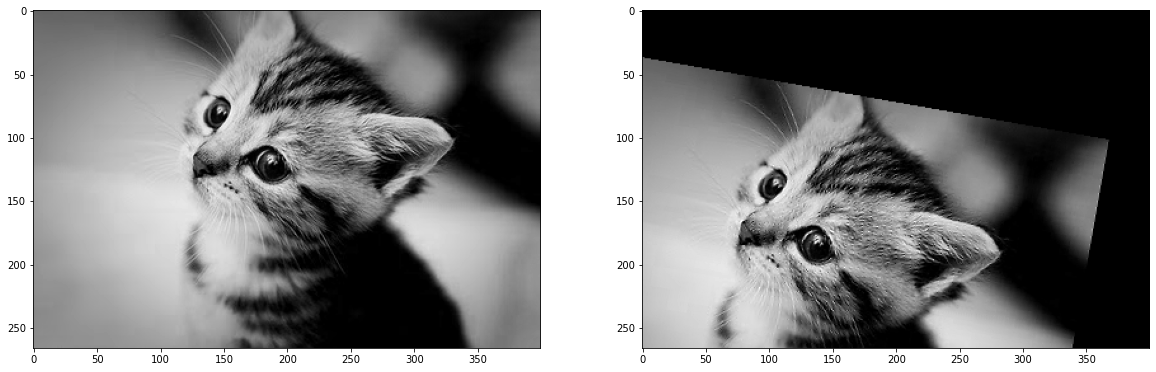

In [12]:
# Muestre las matrices correspondientes a las tres transformaciones 
alto, ancho=np.shape(I)
centro_x = ancho / 2
centro_y = alto / 2
angulo=10
T1 = np.array([
    [1, 0, -centro_x],
    [0, 1, -centro_y],
    [0, 0, 1]
])

matriz_rotacion = np.array([[np.cos(np.deg2rad(angulo)), -np.sin(np.deg2rad(angulo)),0],
                            [np.sin(np.deg2rad(angulo)), np.cos(np.deg2rad(angulo)),0],
                            [0,0,1]])

T2 = np.array([
    [1, 0, centro_x],
    [0, 1, centro_y],
    [0, 0, 1]
])

H=T1@matriz_rotacion@T2


I_bilineal=transformar(I, H, tipo_interpolacion='bilineal', color_de_fondo=0)
fig, axs = plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(I,cmap="gray")
axs[1].imshow(I_bilineal,cmap="gray")
# Calcule la matriz de rotación en el centro como la composición de las tres transformaciones anteriores



# Aplique la transformación y muestre el resultado



#### Mostrar una transformación afin 

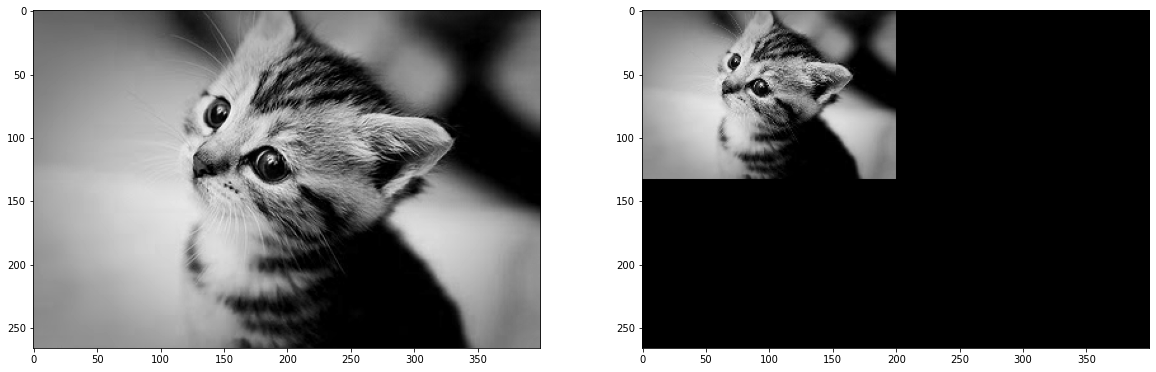

In [14]:
T1 = np.array([
    [0.5, 0, 0],
    [0, 0.5,0],
    [0, 0, 1]
])
I_bilineal=transformar(I, T1, tipo_interpolacion='bilineal', color_de_fondo=0)
fig, axs = plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(I,cmap="gray")
axs[1].imshow(I_bilineal,cmap="gray")


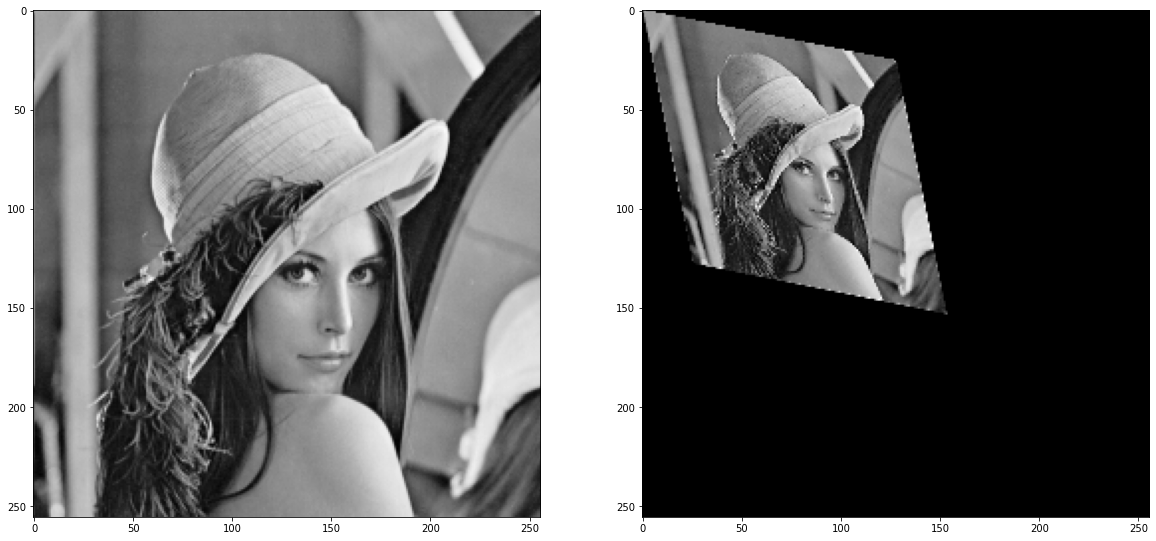

In [82]:
filenames = [dir_base_imagenes+'lena.bmp']

I = cv2.imread(filenames[0])
I=I[:,:,0]
T1 = np.array([
    [0.5, 0.1, 0],
    [0.1, 0.5,0],
    [0, 0, 1]
])
I_bilineal=transformar(I, T1, tipo_interpolacion='bilineal', color_de_fondo=0)
fig, axs = plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(I,cmap="gray")
axs[1].imshow(I_bilineal,cmap="gray")

#### Mostrar una transformación proyectiva

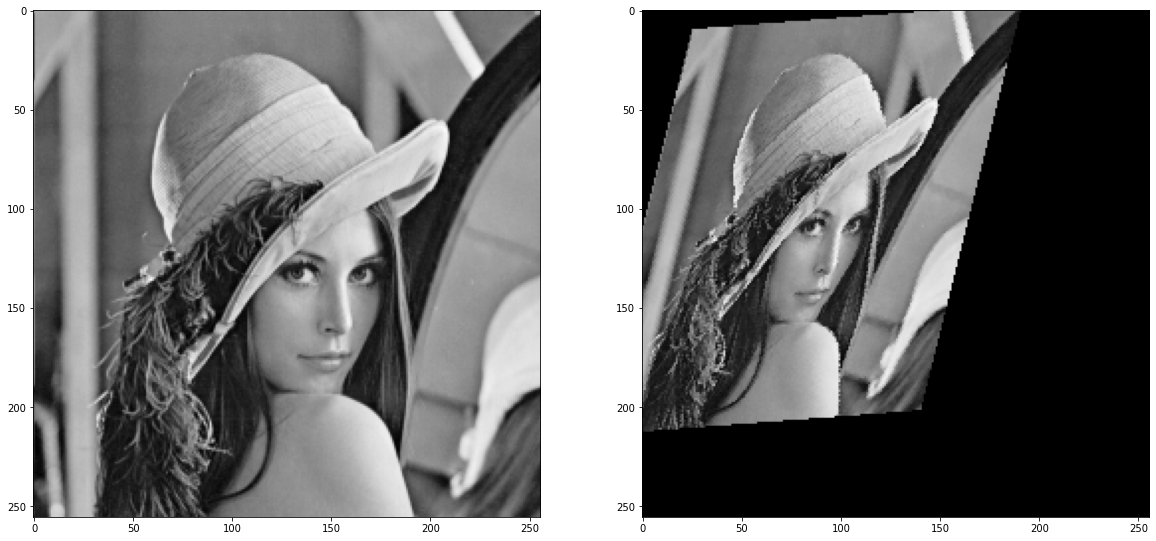

In [83]:
T1 = np.array([
    [0.9, 0.05, 25],
    [0.05, 0.9,10],
    [0.01, 0.01, 1]
])
I_bilineal=transformar(I, T1, tipo_interpolacion='vecino', color_de_fondo=0)
fig, axs = plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(I,cmap="gray")
axs[1].imshow(I_bilineal,cmap="gray")

### 3. Implementar el cálculo de una matriz de transformación proyectiva a partir de un conjunto de  4 o más puntos correspondientes
Para chequear su implementación se puede comparar el resultado con cv2.findHomography por ejemplo


In [14]:
# Entradas:
#    puntosA   Nx2
#    puntosB   Nx2
#    con N>=4
# Salida
#    H         3x3    
def calcular_homografia(puntosA, puntosB):   
    A = []
    for i in range(len(puntosA)):
        x, y = puntosA[i]
        u, v = puntosB[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.asarray(A)
    U, S, V = np.linalg.svd(A)
    h = V[-1,:] / V[-1,-1]
    H = h.reshape((3, 3))
    print(H)
    
    return H
    

#### Chequear la función implementada

In [16]:
# chequear la función calcularHomografía con un conjunto de puntos N=4
origen =  np.array([(0,0), (0,100), (100, 100), (100, 0)])
destino = np.array([(0,0), (0,100), (100, 50),  (100, 0)])
print(origen)
print(destino)

# calcular la homografía
#h, status = cv2.findHomography(origen, destino)
h=calcular_homografia(origen, destino)

print(h)
# h, status = cv2.findHomography(origen, destino)
# print(h)
# aplicar a los puntos origen y verificar si el resultado son los puntos destino




[[  0   0]
 [  0 100]
 [100 100]
 [100   0]]
[[  0   0]
 [  0 100]
 [100  50]
 [100   0]]
[[ 2.00000000e+00  2.32581924e-16  0.00000000e+00]
 [-2.87034998e-15  1.00000000e+00  2.74323979e-13]
 [ 1.00000000e-02 -1.03079459e-16  1.00000000e+00]]
[[ 2.00000000e+00  2.32581924e-16  0.00000000e+00]
 [-2.87034998e-15  1.00000000e+00  2.74323979e-13]
 [ 1.00000000e-02 -1.03079459e-16  1.00000000e+00]]
[[ 2.00000000e+00 -2.28237351e-18  0.00000000e+00]
 [ 1.41552347e-16  1.00000000e+00  2.83104694e-14]
 [ 1.00000000e-02 -4.56474702e-20  1.00000000e+00]]


In [ ]:
# chequear la función calcularHomografía con un conjunto de puntos N>4
origen =  np.array([(0,0), (0,52), (0,100), (100, 100), (100, 0)])
destino = np.array([(0,0), (0,48), (0,100), (100, 50),  (100, 0)])
print(origen)
print(destino)


# calcular la homografía


# aplicar a los puntos origen y verificar si el resultado es cercano a los puntos destino


## Segmentación

### 4. Detección de líneas con la transformada de Hough

   
Se puede encontrar una buena explicación y pseudocódigo en los libros de [Burger & Burge](https://books.google.com.uy/books?id=YpzWCwAAQBAJ&printsec=frontcover#v=onepage&q&f=false).   
Se sugiere seguir dicho pseudocódigo para la implementación.

#### Dibujo de líneas

In [2]:
def plot_lineas_hough(fig,img, L):
      """ Grafica sobre la figura especificada las líneas definidas en L


      Args:
          fig (_type_): Numero de la figura de matplotlib donde se plotean las líneas
          img (_type_): imagen sobre la cual plotear
          L (_type_): [[rho, theta, votos], [theta, rho, votos], .....]
          Lista de rectas detectadas con la función lineas_hough 
      """
      ancho=img.shape[1]
      alto=img.shape[0]
      for linea in L:
        theta=linea[1]
        rho=linea[0]
        if np.sin(theta)==0:
          m=0
          b=0
        else:   
          m = -np.cos(theta) / np.sin(theta)
          b = rho / np.sin(theta)
        print(m)
        print(b)
        x0 = 0
        y0 = m * x0 
        x1 =ancho - 1 
        y1 = m * x1 + b
        x = np.array([x0, x1])
        y = np.array([y0+alto//2, y1+alto//2])
        print(x)
        print(y)

        fig.imshow(img, cmap='gray')
        fig.plot(x, y)



In [93]:
def plot_lineas_hough(fig,img, L):
      """ Grafica sobre la figura especificada las líneas definidas en L


      Args:
          fig (_type_): Numero de la figura de matplotlib donde se plotean las líneas
          img (_type_): imagen sobre la cual plotear
          L (_type_): [[rho, theta, votos], [theta, rho, votos], .....]
          Lista de rectas detectadas con la función lineas_hough 
      """
      x0=img.shape[1]//2
      y0=img.shape[0]//2
      for linea in L:
        theta=linea[1]
        rho=linea[0]
        a = np.cos(theta)
        b = np.sin(theta)
        xr = (a * rho) + x0
        yr = (b * rho) + y0
        if np.tan(theta) == 0:
          x_ini = 0
          x_fin = np.shape(img)[1]
          y_ini = y_fin = yr
          
        else:
          x_ini = xr - (1/np.tan(theta))*(-xr)
          x_fin = xr - (1/np.tan(theta))*(np.shape(img)[1]-xr)
          y_ini = 0
          y_fin = np.shape(img)[0]
        fig.plot([x_ini,x_fin], [y_ini, y_fin])

        fig.imshow(img, cmap='gray')





#### Mostrar el funcionamiento de plot_lineas_hough para distintos valores theta-rho
Notar que se puede implementar y probar **plot_lineas_hough** antes de implementar **lineas_hough**.  
Se sugiere dejar andando correctamente **plot_lineas_hough** primero. Esto permitirá luego probar rápidamente los resultados de **lineas_hough**.
  

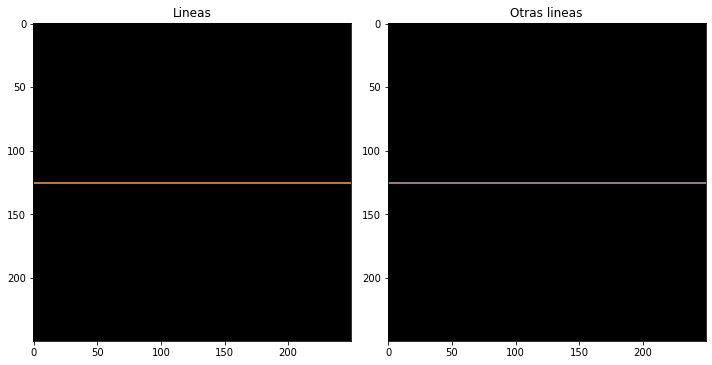

In [94]:
# Imagen vacía a plottear
zeros = np.zeros((250,250))

# líneas horizontal y vertical que pasan por la mitad de la imagen
lineas = [[0,0],[0,np.pi/2]]    
# lineas separadas por un ángulo de pi/8 radianes
lineas2 = [[0,0],[0,np.pi/8],[0,np.pi/4],[0,3*np.pi/8],[0,np.pi/2],[0,5*np.pi/8],[0,3*np.pi/4],[0,7*np.pi/8]] 

# Inicializar figura
fig, ax = plt.subplots(1,2,figsize=(10,10))
# Plot lineas
plot_lineas_hough(ax[0],zeros, lineas)
ax[0].set_title("Lineas")
# Plot lineas2
plot_lineas_hough(ax[1],zeros, lineas2)
ax[1].set_title("Otras lineas")
fig.tight_layout()
plt.show()

Las imágenes de salida deberían ser del estilo:


![Alt text](imagenes/output_plot_hough.png)

#### Detección de líneas

In [110]:

def is_local_max(A,i,j):
    max=0
    for k in range(i-1, i+2):
        for l in range(j-1,j+2):
            try:
                if max<A[k,l]:
                    max=A[k,l]
            except:
                pass
    return(max<=A[i,j]) 


def lineas_hough(I, m, n, minimo_votos, debug=False):
    '''
    Detección de líneas mediante la Transformada de Hough
    
    Args
    ----
    I : imagen binaria (resultado de un detector de bordes por ejemplo)
    m, n : Enteros que determinan las dimensiones del acumulador
           m: cantidad de pasos en Theta
           n: cantidad de pasos en Rho
    minimo_votos : Cantidad mínima de votos que debe tener una recta 
    debug : Booleano opcional. En caso de ser verdadero, se muestra la imagen del acumulador
    
    Returns
    -------
    L : [[rho, theta, votos], [theta, rho, votos], .....]
        Lista con las rectas detectadas donde cada elemento de la lista es una terna [theta, rho, votos]
        La lista está ordenada en forma decreciente en la cantidad de votos 

    '''
    M,N=I.shape
    xr=M//2
    yr=N//2
    dtita=np.pi/m
    dr=np.sqrt(M**2+N**2)/n
    j0=n/2
    A=np.zeros((m,n))
    for u in range (M):
        for v in range (N):
            if I[u,v]>0:
                x=u-xr
                y=v-yr
                for i in range (m):
                    tita=(dtita*i)
                    r=x*np.cos(np.radians(tita))+y*np.sin(np.radians(tita))
                    j=int(j0+np.round(r/dr))
                    A[i,j]=A[i,j]+1
    L=[]
    for i in range(m):
        for j in range(n):
            if A[i,j]>=minimo_votos and is_local_max(A,i,j):
                tita=np.radians(dtita*i)
                r=(j-j0)*dr
                a=A[i,j]
                L.append([r, tita, a])
    sorted(L)
    return L



#### Mostrar el funcionamiento de lineas_hough sobre imágenes artificiales 
Para cada imagen artificial:   
a) detectar líneas  
b) mostrar el acumulador y plotear las rectas    
c) relacionar el contenido del acumulador con las rectas correspondientes    

[[-50.117162728949445, 0.0, 2.0], [-50.117162728949445, 5.483113556160755e-05, 2.0], [-50.117162728949445, 0.0001096622711232151, 2.0], [-50.117162728949445, 0.00016449340668482263, 2.0], [-50.117162728949445, 0.0002193245422464302, 2.0], [-50.117162728949445, 0.00027415567780803777, 2.0], [-50.117162728949445, 0.00032898681336964526, 2.0], [-50.117162728949445, 0.00038381794893125286, 2.0], [-50.117162728949445, 0.0004386490844928604, 2.0], [-50.117162728949445, 0.0004934802200544679, 2.0], [-50.117162728949445, 0.0005483113556160755, 2.0], [-50.117162728949445, 0.000603142491177683, 2.0]]


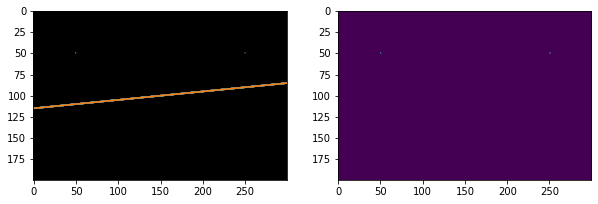

In [111]:
#Ejemplo 1 
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255
L=lineas_hough(I, 1000, 1000, 1.1, debug=False)
print(L)
fig, ax=plt.subplots(1,2,figsize=(10,10))

plot_lineas_hough(ax[0],I, L)

ax[1].imshow(I)
plt.show()


[[-99.8737703303525, 3.1384510609362035, 2.0]]


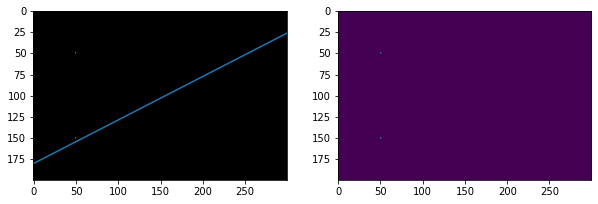

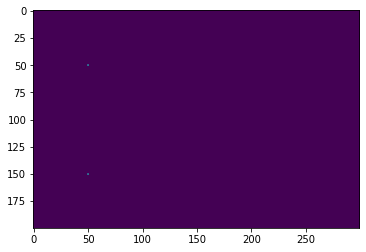

In [101]:
#Ejemplo 2
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[150,50]=255
L=lineas_hough(I, 1000, 1000, 1.1, debug=False)
print(L)
fig, ax=plt.subplots(1,2,figsize=(10,10))

plot_lineas_hough(ax[0],I, L)

ax[1].imshow(I)
plt.show()


[[-35.33440249954709, 3.1384510609362035, 2.0]]


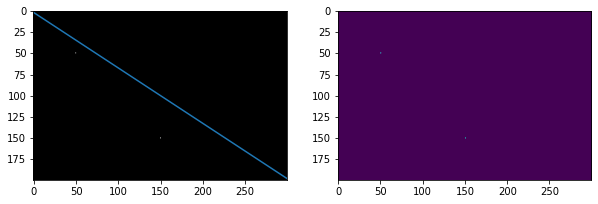

In [103]:
#Ejemplo 3
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[150,150]=255
L=lineas_hough(I, 1000, 1000, 1.1, debug=False)
print(L)
fig, ax=plt.subplots(1,2,figsize=(10,10))

plot_lineas_hough(ax[0],I, L)

ax[1].imshow(I)
plt.show()

[[-50.117162728949445, 3.1384510609362035, 2.0], [35.33440249954709, 3.1384510609362035, 2.0], [-35.33440249954709, 3.1384510609362035, 2.0]]


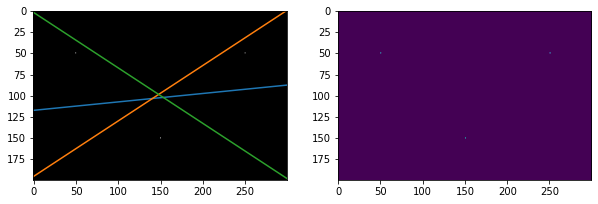

In [102]:
# Ejemplo 4
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255
I[150,150]=255
L=lineas_hough(I, 1000, 1000, 1.1, debug=False)
print(L)
fig, ax=plt.subplots(1,2,figsize=(10,10))

plot_lineas_hough(ax[0],I, L)

ax[1].imshow(I)
plt.show()


#### Mostrar el funcionamiento de lineas_hough sobre la imagen trapecio.png
Comentar resultados al variar la resolución en el espacio de parámetros (m y n en la función lineas_hough)

### 5. Aplicación: Segmentación de imágenes de documentos

En esta parte se usará un subset de la base RVL-CDIP que contiene imágenes de documentos escaneados.
https://adamharley.com/rvl-cdip/  


Utilizando herramientas vistas en el curso (ej. análisis en frecuencia, transformaciones geométricas, segmentación por umbral, detección de bordes, lineas y regiones, morfología, etiquetado de regiones, entre otros) se buscará identificar en cada imagen:  

**Tareas**

1. Orientación general del documento en la imagen.  ¿El documento está en formato vertical o está apaisado? 
2. Ángulo de giro. Ángulo a girar el documento en sentido horario para que las líneas y/o texto queden horizontales.  
3. ¿El documento es un formulario o tabla? Se entenderá por formulario o tabla un documento que cuente con algunas líneas verticales y horizontales. 
4. ¿El documento tiene columnas de texto? El documento tiene agrupaciones de texto en columnas por varias filas.  
5. Límites horizontales del documento. Indicar la columna de inicio y fin del núcleo principal del documento. En caso que (4) sea afirmativo, indicar también las posiciones horizontales que separan las columnas de texto.    
6. Alto de líneas. Distancia vertical en píxeles entre la línea de base de una fila y la de la siguiente.  
7. Ancho de letra. En los casos que el documento tenga un tipo de letra "monospaced" (https://en.wikipedia.org/wiki/Monospaced_font) se podrá determinar el ancho de letra como la distancia horizontal en píxeles entre el comienzo de una letra y de la siguiente. 
8. ¿El documento es sólo texto y/o líneas o contiene alguna figura? Se entenderá por figura un conjunto conexo de píxeles mayor al 1% del área de la imagen y que no está compuesto por texto/líneas y que tampoco es una región quasi-uniforme (ej. un rectángulo quasi-uniforme no se considera una figura)

En el pdf adjunto a este notebook hay ejemplos de las imágenes de documentos y de los resultados esperados para cada una de las tareas. 


**Herramientas**  
Para la resolución de esta parte se podrá usar funciones de numpy, scipy, scikit-image, de OpenCV y herramientas de Fiji. 

**Resultados esperados**
* El problema se plantea en forma abierta y por lo tanto no hay una forma única de resolver cada tarea. La idea es que exploren las distintas técnicas y algoritmos vistos a lo largo del curso sobre un problema concreto
* El conjunto de imágenes que les dejamos disponibles tiene cierta variabilidad por lo que, para las distintas tareas, habrá algunas imágenes más complicadas que otras. No esperen un funcionamiento perfecto de sus soluciones. 
* Para cada tarea implementada, 
  * se valorará que comenten él o los posibles métodos que la podrían resolver, antes de realizar una implementación concreta
  * implementen alguno de esos métodos en la función cuyo esqueleto le pasamos. Pueden hacer funciones auxiliares si lo necesitan. Alternativamente pueden hacer un procedimiento o una macro si usan Fiji.
  * muestren tests de su método sobre algunas imágenes
  * opcionalmente pueden mostrar, si la tarea lo permite, resultados cuantitativos sobre el conjunto de imágenes (por ejemplo el porcentaje de acierto)
  * comenten en qué casos funciona y qué casos son difíciles para el método (no es necesario un listado exhaustivo)  
* Implementaciones  
  * No se espera que un método implementado para una tarea funcione para todas o casi todas las imágenes. 
  * Las tareas tienen diferente dificultad. Para algunas será más sencillo hacer un método general y para otras se podrá hacer algo que funcione para un conjunto más restringido de imágenes. Hagan métodos no muy extensos, los testean y discuten resultados.
  * Realizar al menos 5 de las 8 tareas
   
  



##### 5.1 Orientación general

Discusión de métodos, pruebas

Implementación

In [11]:
def tiene_orientacion_vertical(I_doc):
    """
    Determina la orientación del documento en la imagen.

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    orientacion_vertical (bool): Orientación del documento, puede ser 'vertical' (True) o 'apaisado' (False)
    """

    # IMPLEMENTAR #

    return orientacion_vertical

Tests sobre imágenes

##### 5.2 Ángulo de giro

Discusión de métodos, pruebas

Implementación

In [ ]:
def angulo_de_giro(I_doc):
    """
    Determina el ángulo (en grados) a girar la imagen en sentido horario 
    para que las líneas y/o texto del documento queden horizontales.

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    angulo (double): ángulo en grados
    """

    # IMPLEMENTAR #

    return angulo

Tests sobre imágenes

##### 5.3 Es un formulario o tabla ?

Discusión de métodos, pruebas

Implementación

In [ ]:
def es_tipo_tabla(I_doc):
    """
    Determina si el documento en la imagen es tipo formulario/tabla

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    es_tabla (bool): Verdadero si el documento en la imagen es tipo formulario/tabla
    """

    # IMPLEMENTAR #

    return es_tabla

Tests sobre imágenes

##### 5.4 ¿El documento tiene texto en columnas?

Discusión de métodos, pruebas

Implementación

In [ ]:
def tiene_texto_en_columnas(I_doc):
    """
    Determina si el documento tiene texto en columnas

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    tiene_columnas (bool): Verdadero en caso de tener columnas
    """

    # IMPLEMENTAR #

    return tiene_columnas

Tests sobre imágenes

##### 5.5 Límites horizontales

Discusión de métodos, pruebas

Implementación

In [ ]:
def limites_horizontales(I_doc):
    """
    Devuelve una lista de valores con las columnas de inicio y fin del contenido del documento
    y, si contiene columnas, las posiciones horizontales que separan las columnas

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    limites (list): [inicio, fin] si el documento no contiene texto en columnas
                    [inicio, sep1,...,sepN, fin] si contiene columnas 
    """

    # IMPLEMENTAR #

    return limites

Tests sobre imágenes

##### 5.6 Alto de línea

Discusión de métodos, pruebas

Implementación

In [ ]:
def alto_de_linea(I_doc):
    """
    Devuelve el alto de línea del documento

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    alto (int o double): Alto de la línea 
    """

    # IMPLEMENTAR #

    return alto

Tests sobre imágenes

##### 5.7 Ancho de letra

Discusión de métodos, pruebas

Implementación

In [10]:
def ancho_de_letra(I_doc):
    """
    Devuelve el ancho de letra del documento
    Se supone que la imagen pasada comprende un documento que, mayoritariamente,
    tiene tipo de letra "monospaced" 

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    ancho (int o double): ancho de letra 
    """

    # IMPLEMENTAR #

    return ancho

Tests sobre imágenes

##### 5.8 ¿El documento contiene figuras?

Discusión de métodos, pruebas

Implementación

In [ ]:
def tiene_alguna_figura(I_doc):
    """
    Determina si el documento tiene alguna figura

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    tiene_figura (bool): Verdadero en caso de tener alguna figura
    """

    # IMPLEMENTAR #

    return tiene_figura

Tests sobre imágenes